# Coronal 3 Cortex IF Alignment

This notebook processes coronal 3 cortex imaging data by:
- Creating a SpatialData object from a Zarr file.
- Aligning DAPI, presynaptic, and postsynaptic IF images using transformation matrices.
- Cropping the SpatialData object to the region-of-interest (ROI) based on the aligned images.
- Visualizing the alignment results.

This workflow is essential for verifying the quality of the tissue staining and the alignment between the imaging modalities.


In [1]:
import spatialdata as sd
import spatialdata_io as sdio
import spatialdata_plot
import matplotlib.pyplot as plt
import path

## Create SpatialData Object

Here we load the SpatialData object from a previously converted Zarr file. This object contains the morphological, label, point, shape, and table data required for further processing.

In [2]:
# Create a spatialdata object
sdata = sd.read_zarr("/mnt/d/synapse/data/sdata/coronal3.zarr")
sdata

/home/ckmah/mambaforge/envs/synapse/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /mnt/d/synapse/data/sdata/coronal3.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 30759, 39849), (5, 15379, 19924), (5, 7689, 9962), (5, 3844, 4981), (5, 1922, 2490)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (30759, 39849), (15379, 19924), (7689, 9962), (3844, 4981), (1922, 2490)
│     └── 'nucleus_labels': DataTree[yx] (30759, 39849), (15379, 19924), (7689, 9962), (3844, 4981), (1922, 2490)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (137686, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (137686, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (136117, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (137686, 5006)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell

## Align Images

In this section:
- We align the DAPI, presynaptic, and postsynaptic IF images using an alignment matrix.
- The function `sdio.xenium_aligned_image` is used to correct the image coordinates based on the provided transformation matrix.
- The aligned images are then parsed into `Image2DModel` objects and added to the SpatialData object's `images` dictionary.

This alignment ensures that the cropped images correctly overlay on the full tissue image.


In [3]:
# Align the DAPI image using the matrix for transformation.
dapi_align = sdio.xenium_aligned_image(
    path.coronal3_cortex_channel0,  # File path for the DAPI channel image.
    path.coronal3_cortex_matrix,  # Alignment matrix used to correct image coordinates.
    dims=("c", "y", "x"),  # Dimension order: channel, y, x.
)

# Align the presynaptic image using the same matrix.
pre_align = sdio.xenium_aligned_image(
    path.coronal3_cortex_channel1,  # File path for the presynaptic channel image.
    path.coronal3_cortex_matrix,  # Alignment matrix.
    dims=("c", "y", "x"),  # Dimension order.
)

# Align the postsynaptic image using the same matrix.
post_align = sdio.xenium_aligned_image(
    path.coronal3_cortex_channel2,  # File path for the postsynaptic channel image.
    path.coronal3_cortex_matrix,  # Alignment matrix.
    dims=("c", "y", "x"),  # Dimension order.
)

# Parse the aligned images into Image2DModel objects.
dapi_if = sd.models.Image2DModel.parse(dapi_align)
pre_if = sd.models.Image2DModel.parse(pre_align)
post_if = sd.models.Image2DModel.parse(post_align)

# Store the parsed image models in the spatialdata object's images dictionary.
sdata.images["dapi_if"] = dapi_if  # DAPI image.
sdata.images["pre_if"] = pre_if  # Presynaptic immunofluorescence image.
sdata.images["post_if"] = post_if  # Postsynaptic immunofluorescence image.

INFO     `dims` is specified redundantly: found also inside `data`.                                                
INFO     `dims` is specified redundantly: found also inside `data`.                                                
INFO     `dims` is specified redundantly: found also inside `data`.                                                


## Visualize Alignment

We overlay the DAPI image from the tissue with the aligned IF images (with transparency) to assess the quality of the image alignment.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


(0.0, 39849.0, 30759.0, 0.0)

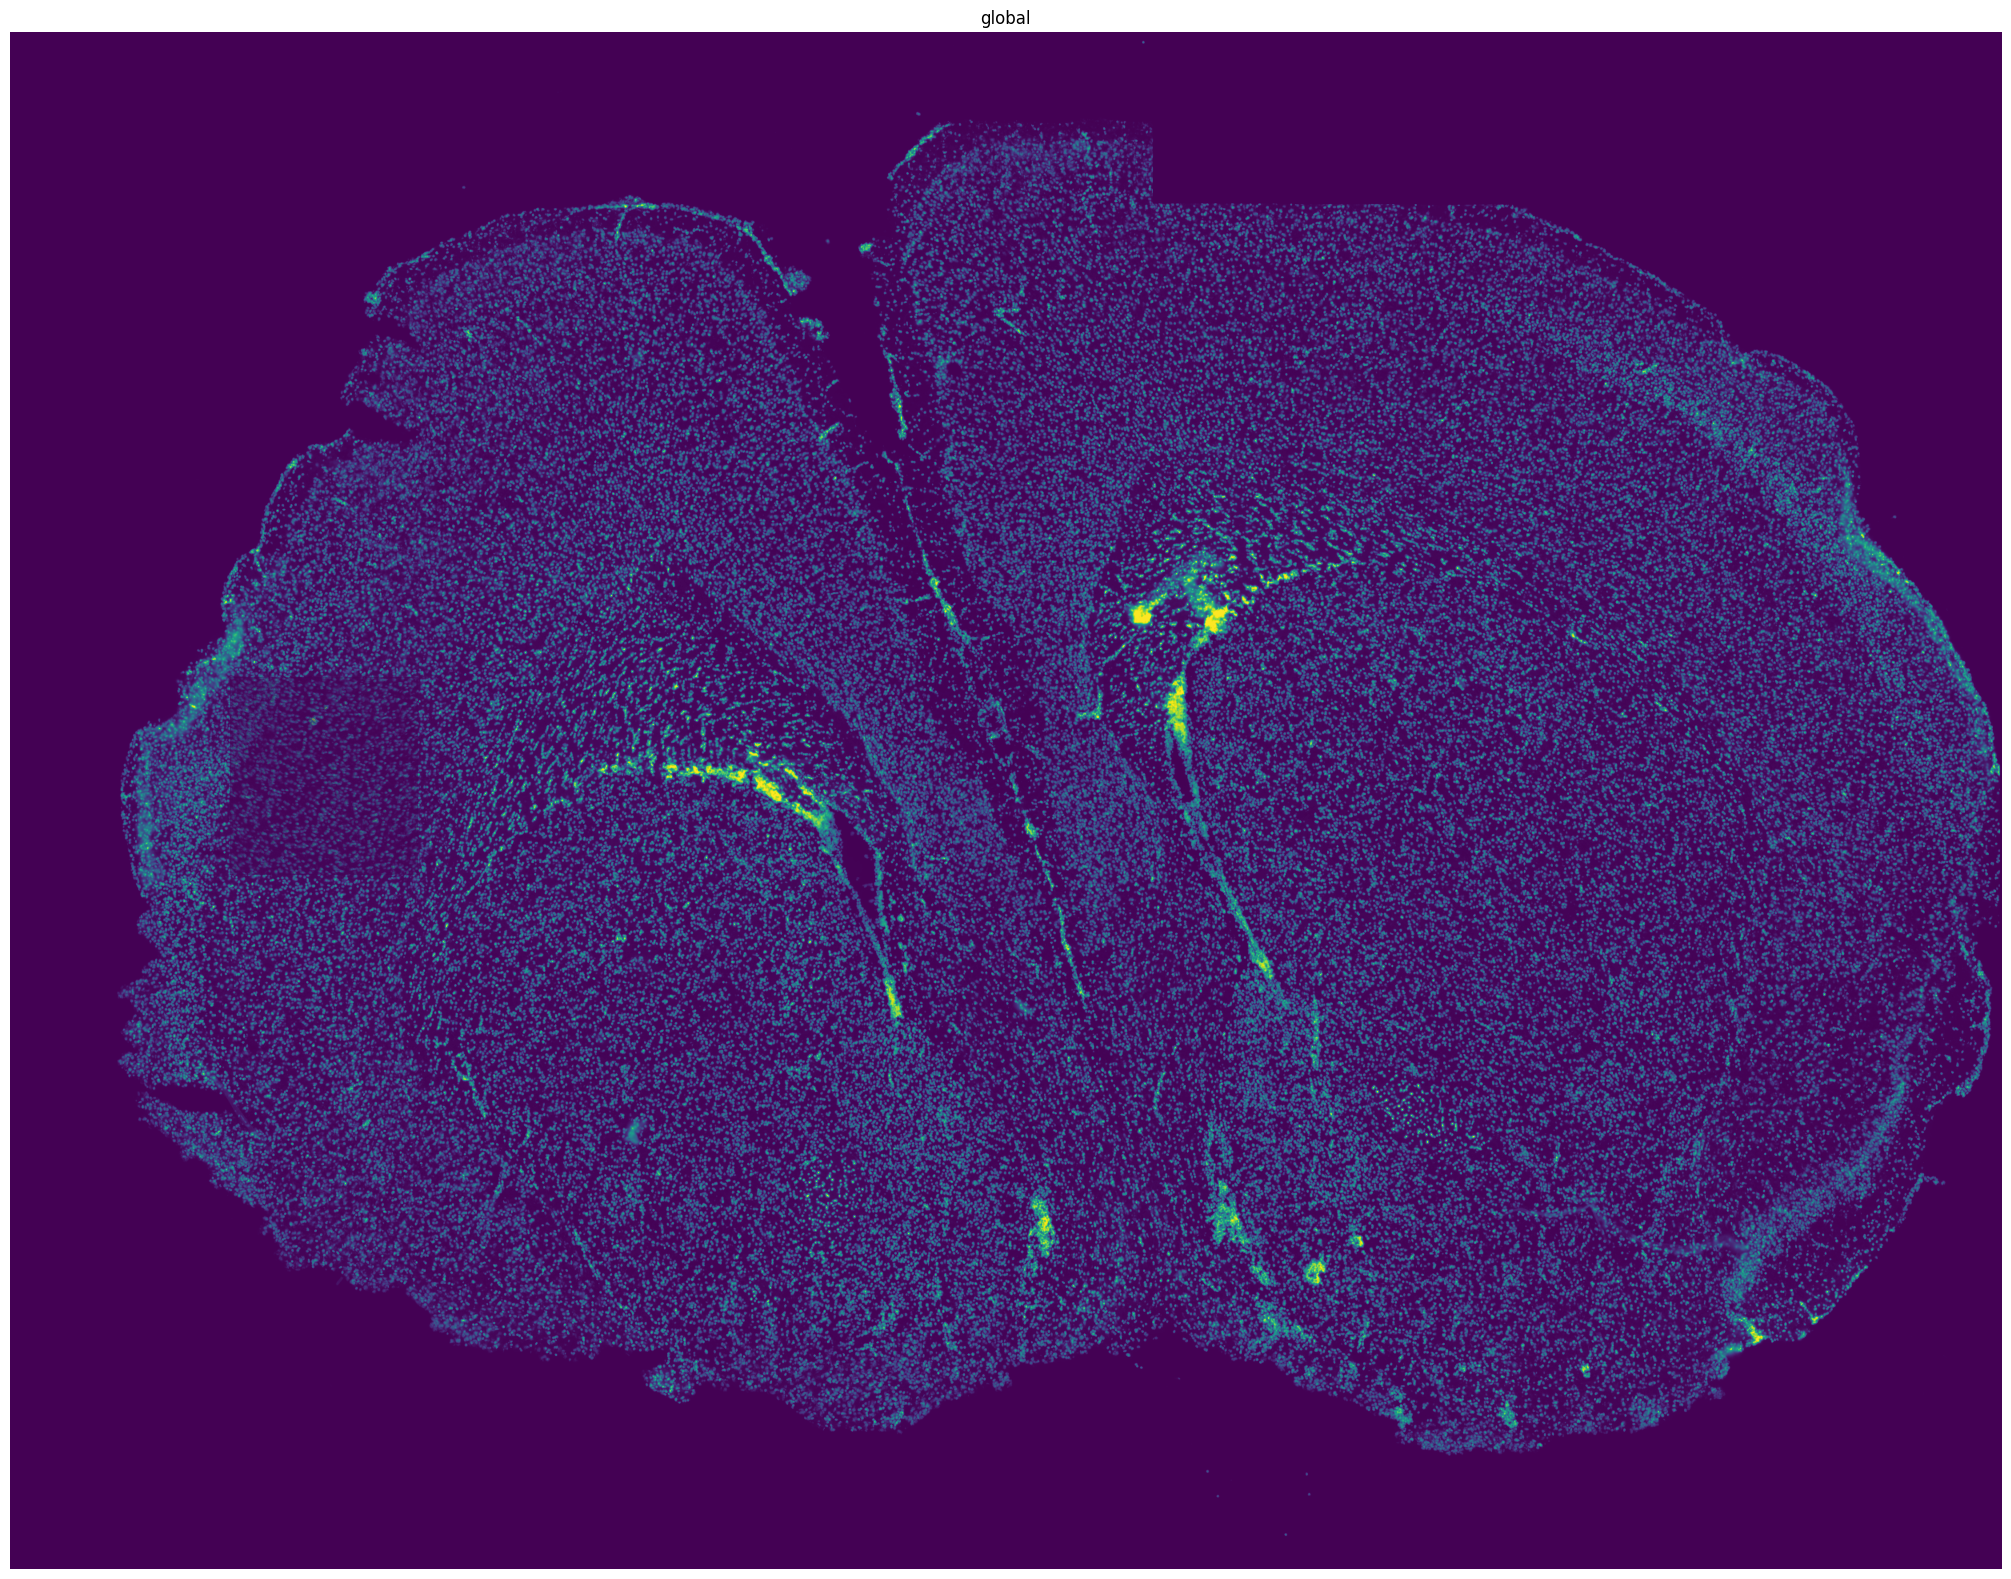

In [4]:
# Visualize alignment using spatialdata_plot.
sdata.pl.render_images("morphology_focus", channel="DAPI", scale="3").pl.render_images(
    "dapi_if", alpha=0.5, scale="3"
).pl.show(colorbar=False, figsize=(20, 20))
plt.axis("off")

## Get Bounds of ROIs and Crop SpatialData Object

This section:
- Uses the `get_extent` function to determine the bounding box of the aligned DAPI image.
- Crops the SpatialData object to the ROI using `bounding_box_query` so that only the relevant area is retained for downstream analysis.
- Helps to reduce data size and focus on the region of interest for further visualization and analysis.

In [5]:
# Get the bounding box of the DAPI image.
bbox = sd.get_extent(sdata["dapi_if"])

# Define the crop extent using the bbox limits.
extent = [[bbox["x"][0], bbox["y"][0]], [bbox["x"][1], bbox["y"][1]]]

# Crop the spatialdata object using the extent.
sdata_cropped = sd.bounding_box_query(
    sdata,
    axes=("x", "y"),
    min_coordinate=extent[0],
    max_coordinate=extent[1],
    target_coordinate_system="global",
)

# Display the cropped spatialdata object.
sdata_cropped

SpatialData object
├── Images
│     ├── 'dapi_if': DataArray[cyx] (1, 8867, 9366)
│     ├── 'morphology_focus': DataTree[cyx] (5, 3960, 3750), (5, 1980, 1875), (5, 989, 938), (5, 494, 468), (5, 247, 234)
│     ├── 'post_if': DataArray[cyx] (1, 8867, 9366)
│     └── 'pre_if': DataArray[cyx] (1, 8867, 9366)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3960, 3750), (1980, 1875), (989, 938), (494, 468), (247, 234)
│     └── 'nucleus_labels': DataTree[yx] (3960, 3750), (1980, 1875), (989, 938), (494, 468), (247, 234)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (2821, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (2729, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (2770, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (2729, 5006)
with coordinate systems:
    ▸ 'global', with elements:
        dapi_if (Images), morphology_focus (Images), post_if

## Visualize Cropped Data

Here we render the cropped DAPI image and overlay the nucleus boundaries to verify:
- The quality of the alignment between the IF images and the nucleus boundaries.
- The accuracy of the cropping procedure.

INFO     Rasterizing image for faster rendering.                                                                   


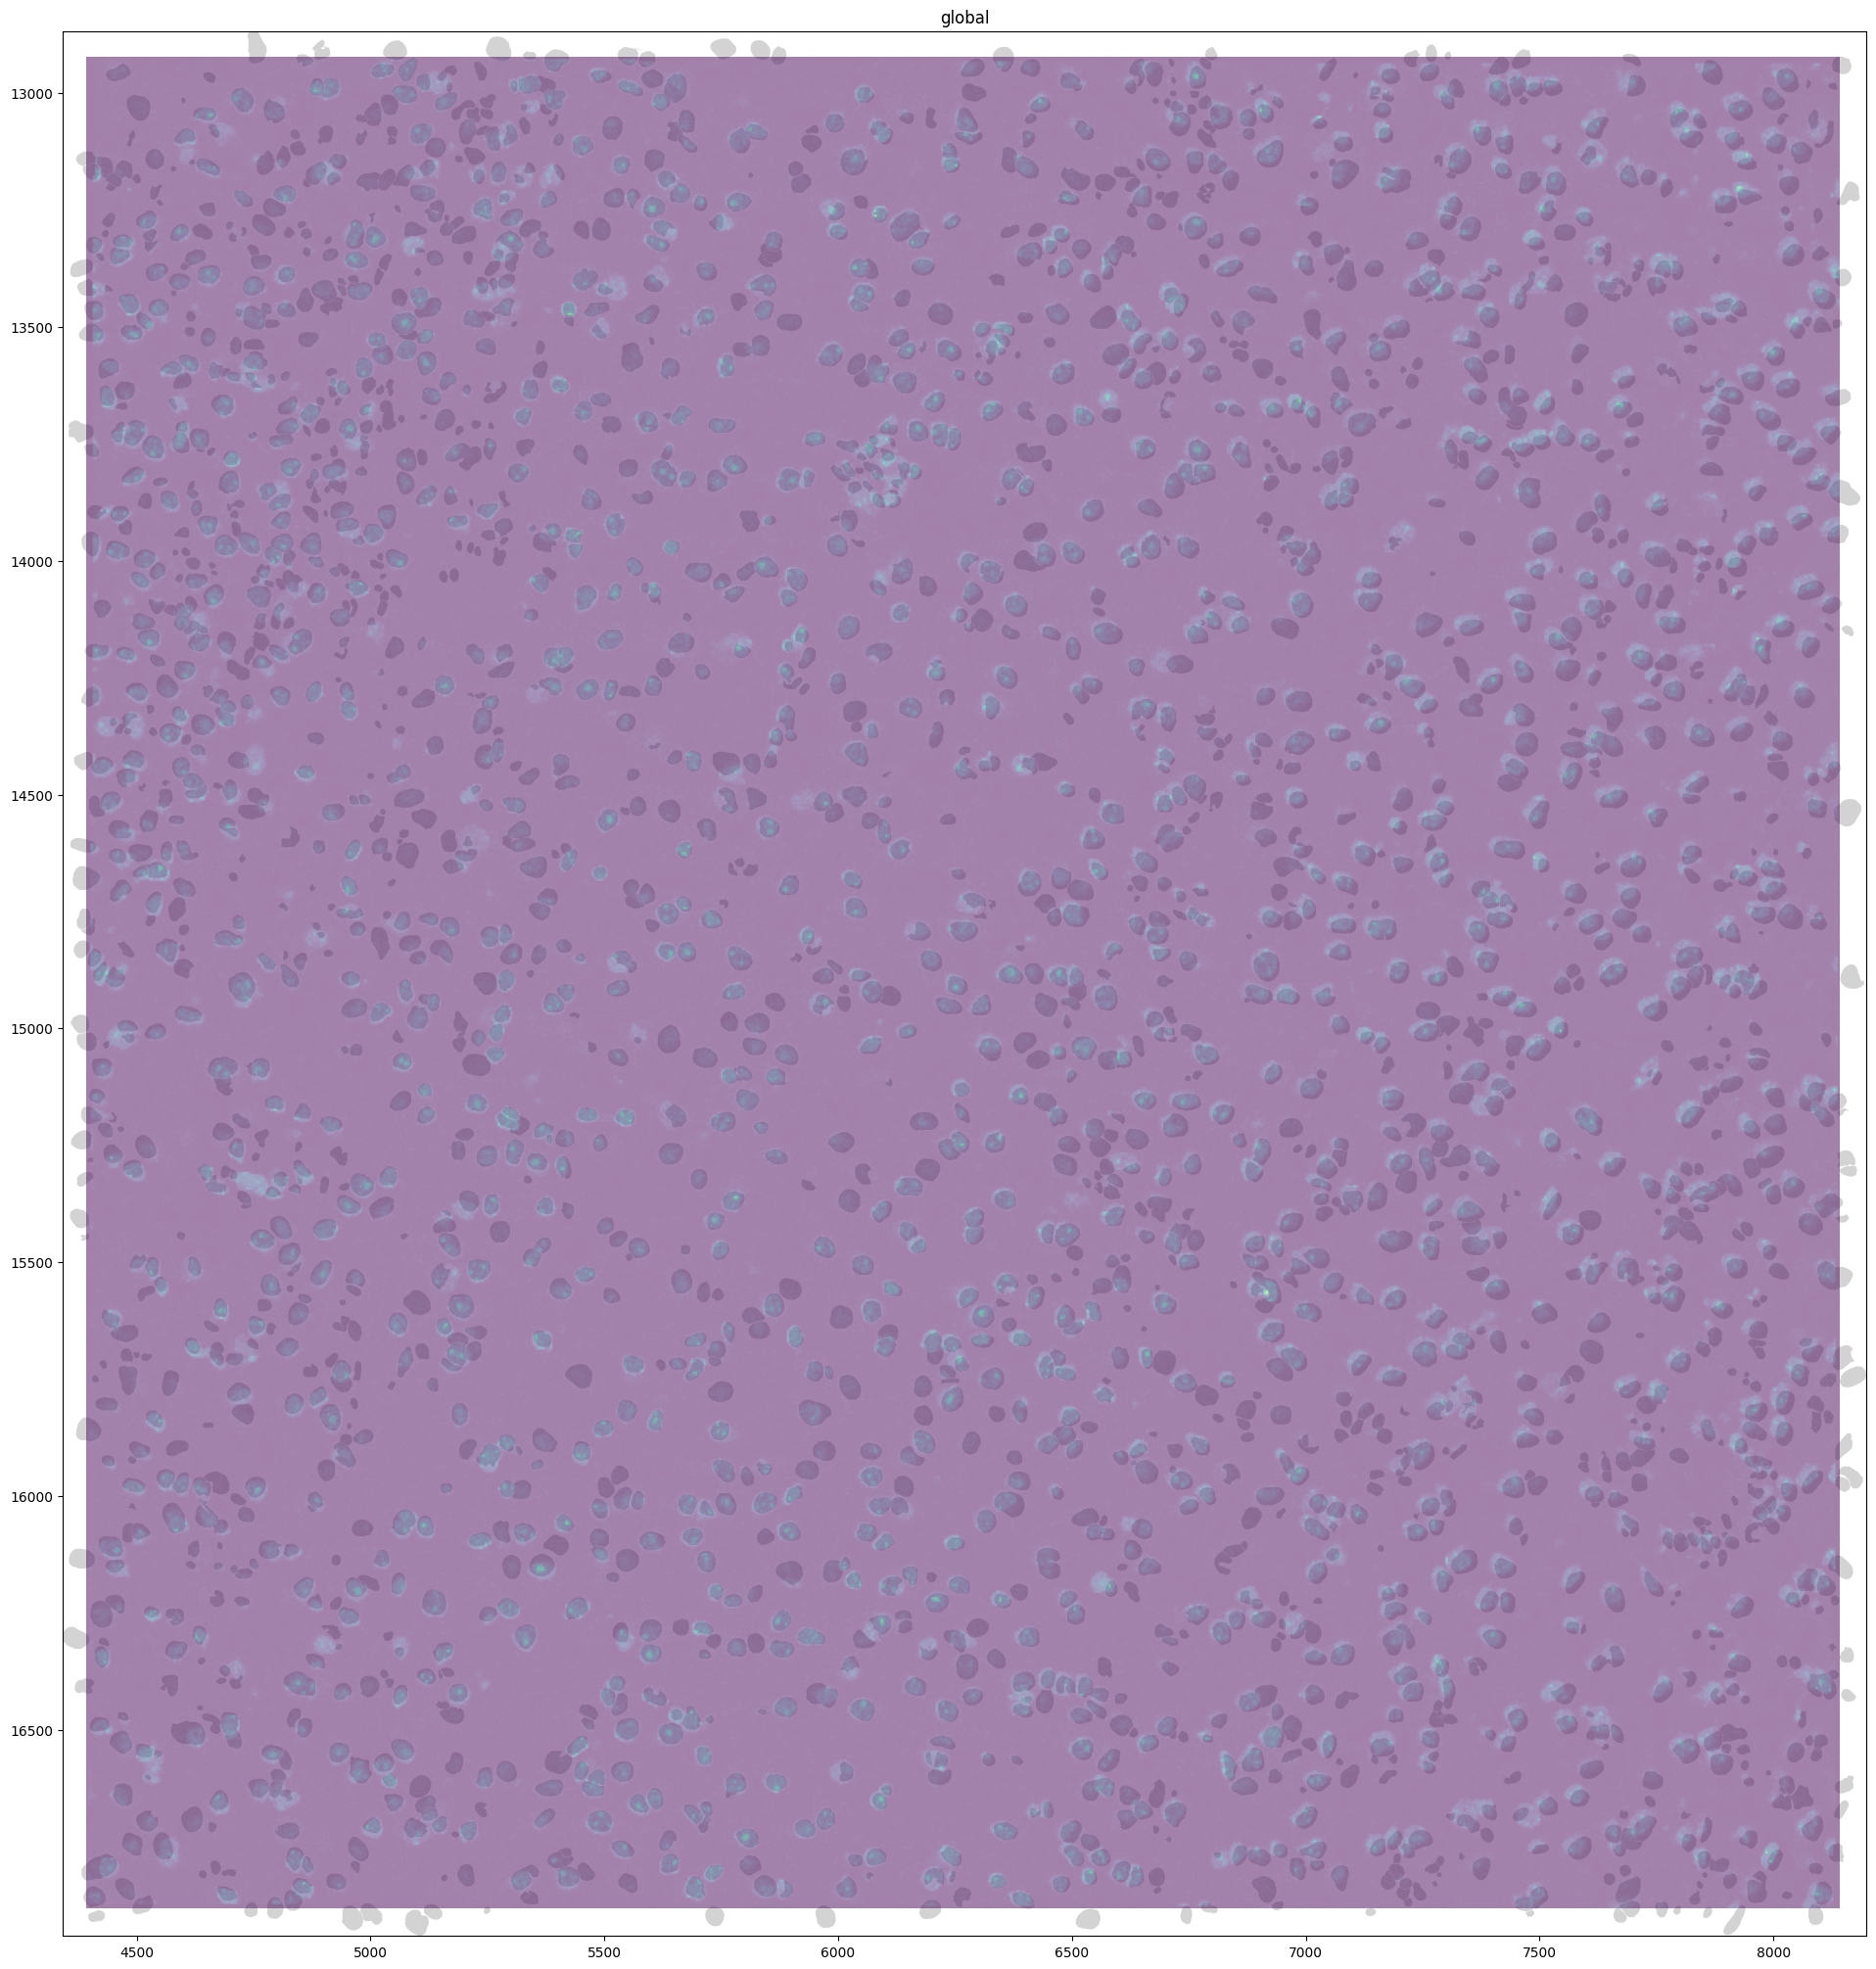

In [6]:
# Visualize aligned nucleus boundaries from Xenium and the dapi image from the IF staining using spatialdata_plot.
sdata_cropped.pl.render_shapes("nucleus_boundaries").pl.render_images(
    "dapi_if", channel="DAPI", scale="3", alpha=0.5
).pl.show(colorbar=False, figsize=(20, 20))

## Saving the Processed SpatialData Object

After aligning and cropping the images, the updated SpatialData object is saved as a condensed Zarr file. This file can be used for downstream analysis and visualization.


In [ ]:
sdata_cropped.write("/mnt/d/synapse/data/sdata_aligned/coronal3_cortex.zarr")